# Parliament Topics & Chess Classifier

This notebook implements two pipelines:

1. **Topic Clustering** using TF-IDF and KMeans on European Parliament debates.
2. **Classification** of chess endgames (K+R vs K) using Gradient Boosting.

In [27]:
# Setup
import warnings, string, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

from sklearn import __version__ as sklearn_version
from packaging import version

if version.parse(sklearn_version) >= version.parse("1.2"):
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
warnings.filterwarnings('ignore')

## Load and preprocess debates

In [29]:
# Preprocessing
def basic_preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.replace('\n', ' ').replace('\r', ' ')

# Load
debates_df = pd.read_csv("debates_2022.csv")
debates_df = debates_df.dropna(subset=["talk_text"])
debates_df["clean_text"] = debates_df["talk_text"].apply(basic_preprocess)
debates_df.head(2)

,Unnamed: 0,speaker_name,speaker_role,speaker_party,date,year,debate_title,talk_text,clean_text
0,81414,Roberta Metsola,NaN,NaN,2022-01-17,2022,Resumption of the session,declaration repeats the session of the europe...,declaration repeats the session of the europe...
1,81415,Roberta Metsola,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,it is with great sadness that today we are pr...,it is with great sadness that today we are pr...


## TF-IDF Vectorisation

In [5]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.9, ngram_range=(1,2))
X = vectorizer.fit_transform(debates_df["clean_text"])
X.shape

(14497, 46122)

## Determine Optimal Number of Clusters (k)

In [7]:
best_k = 2
best_score = -1
for k in range(2, 13):
    labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X)
    score = silhouette_score(X, labels, sample_size=min(5000, X.shape[0]))
    if score > best_score:
        best_k, best_score = k, score
print("Best k:", best_k, "with silhouette score:", best_score)

Best k: 2 with silhouette score: 0.0100713144782601


## KMeans Clustering

In [9]:
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X)
debates_df["cluster"] = labels

terms = np.array(vectorizer.get_feature_names_out())
for i, center in enumerate(kmeans.cluster_centers_):
    top_terms = center.argsort()[::-1][:10]
    print(f"Cluster {i}:", ", ".join(terms[top_terms]))

Cluster 0: closed, 171, written statements, discussion, discussion closed, statements, written, article 171, statements article, closed vote
Cluster 1: european, mr, union, president, energy, europe, eu, commission, people, need


## PCA Visualization

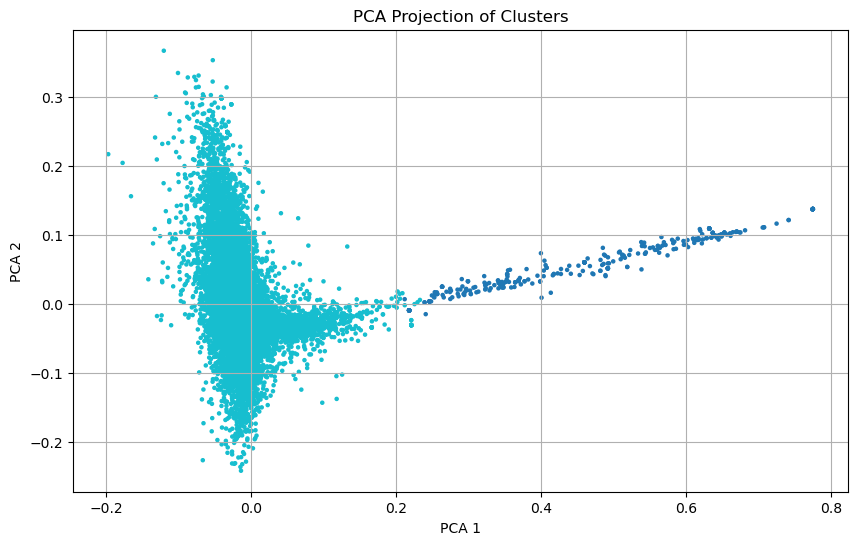

In [11]:
from sklearn.decomposition import PCA
X_dense = X.toarray()
X_pca = PCA(n_components=2).fit_transform(X_dense)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=5, cmap="tab10")
plt.title("PCA Projection of Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# Chess Endgame Classifier

In [33]:
FILE_TO_NUM = {c: i for i, c in enumerate("abcdefgh", start=1)}

def letter_to_num(col):
    return col.map(FILE_TO_NUM)

def recode_targets(series):
    mapping = {
        "draw": 0,
        **{w: 1 for w in ["zero", "one", "two", "three", "four"]},
        **{w: 2 for w in ["five", "six", "seven", "eight"]},
        **{w: 3 for w in ["nine", "ten", "eleven", "twelve"]},
        **{w: 4 for w in ["thirteen", "fourteen", "fifteen", "sixteen"]},
    }
    return series.map(mapping).astype("int8")

df_chess = pd.read_csv("king_rook_vs_king.csv").dropna()
for c in df_chess.columns:
    if c.endswith("_file"):
        df_chess[c] = letter_to_num(df_chess[c])
y = recode_targets(df_chess.pop("white_depth_of_win"))
X = df_chess

## Train Classifier and Evaluate

In [ ]:



file_cols = ["white_king_file", "white_rook_file", "black_king_file"]
rank_cols = ["white_king_rank", "white_rook_rank", "black_king_rank"]
# ct = ColumnTransformer([
#     ("files", OneHotEncoder(handle_unknown="ignore", sparse=False), file_cols),
#     ("ranks", "passthrough", rank_cols)
# ])
ct = ColumnTransformer([
    ("files", encoder, file_cols),
    ("ranks", "passthrough", rank_cols)
])


pipe = Pipeline([
    ("prep", ct),
    ("model", GradientBoostingClassifier(random_state=42))
])

scores = cross_val_score(pipe, X, y, cv=5, scoring="accuracy")
print(f"CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

## Confusion Matrix & Classification Report

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

NameError: name 'pipe' is not defined